# utils & framework

In [1]:
from typing import List, Any
from collections.abc import Iterable
from IPython.core.display import Markdown
from mistune import markdown
from scipy.spatial.transform import Rotation
from sympy import *
from sympy.polys.matrices.dense import ddm_ilu_solve
from sympy.vector import *
from win32cryptcon import CRYPT_MODE_OFB

tag_id = 0
conditions = {}
values = {}
formulas_names = {}
restore_stack = []


def reset():
    global tag_id, conditions, values, formulas_names
    if restore_stack:
        state = restore_stack[-1]
        tag_id = state['tag_id']
        conditions = state['conditions'].copy()
        values = state['values'].copy()
        formulas_names = state['formulas_names'].copy()


def push_state():
    global restore_stack
    restore_stack.append({
        'tag_id': tag_id,
        'conditions': conditions.copy(),
        'values': values.copy(),
        'formulas_names': formulas_names.copy()
    })


def pop_state():
    global restore_stack
    return restore_stack.pop()


def save_as_condition(condition):
    global tag_id, conditions
    cached_condition_id = tag_id
    conditions[tag_id] = condition
    tag_id += 1
    return cached_condition_id


def substitute_values(expression, mask=None):
    while True:
        left = False
        items = values.items() if mask is None else filter(lambda item: item[0] in mask, values.items())
        for (key, value) in items:
            before = str(expression)
            expression = expression.subs(key, value)
            expression = simplify(expression)
            if str(expression) != before:
                left = True
        if not left:
            break

    return expression


def save_as_variable(symbol, value):
    global values
    if symbol in values.keys():
        raise ValueError(f"variable {symbol} already exists")
    values[symbol] = substitute_values(S(value))


def save_as_formula_name(symbol, formula):
    global tag_id, formulas_names
    tag_id += 1
    if symbol in formulas_names.keys():
        raise ValueError(f"formula {symbol} already exists")
    formulas_names[symbol] = formula


def beautiful_print(expression, message="", tag=None):
    expression = expression if isinstance(expression, str) else latex(expression)
    inline = not message.endswith('$')
    tag_str = f'\\tag{{{tag}}}' if tag is not None else ""
    if inline:
        full_latex = message + '$' + expression + '$'
    else:
        full_latex = message + '$' + expression + tag_str + '$$'
    display(Markdown(full_latex))


def beautiful_answer(expression, message="$", f: bool = False):
    expression = spf(expression)
    expression = expression.evalf() if f else expression
    beautiful_print(expression, message, tag="answer")


def beautiful_peek(symbol, message="$", tag=None):
    value = substitute_values(symbol)
    beautiful_print(Eq(symbol, value, evaluate=False), message, tag)


def beautiful_solve(cond, variables, apply: dict = None):
    cond = [cond] if not isinstance(cond, Iterable) else cond
    display(Markdown(f"${','.join(f"\\left ( {i} \\right ) " for i in cond)} \\Longrightarrow$"))

    variables = [variables] if not isinstance(variables, Iterable) else variables

    apply = apply if apply is not None else {}

    cond = tuple(map(lambda i: conditions[i].subs(apply), cond))
    solution = solve(cond, tuple(variables), dict=True)[0]
    conclusions = []
    for (variable, conclusion) in solution.items():
        beautiful_print(Eq(variable, conclusion), "$")
        save_as_variable(variable, conclusion)
        conclusions.append(conclusion)


def beautiful_condition(expression, message="$"):
    beautiful_print(expression(False) if callable(expression) else expression, message, tag_id)
    return save_as_condition(expression(True) if callable(expression) else expression)


def beautiful_compute(symbol, expression=None, message="$", tag=None):
    symbol = symbols(symbol) if isinstance(symbol, str) else symbol
    global tag_id
    beautiful_print(Eq(symbol, expression(False) if callable(expression) else expression, evaluate=False), message,
                    tag_id if tag else None)
    if tag:
        tag_id += 1
    save_as_variable(symbol, expression(True) if callable(expression) else expression)
    return symbol


def beautiful_formula(symbol: str, expression: object, message: object = "$", ) -> Any:
    beautiful_print(f"{symbol}=" + latex(expression), message, tag_id)
    save_as_formula_name(expression, symbol)
    return expression


def beautiful_at(formula, subs: dict, message="$", tag: bool = None):
    result = simplify(formula.subs(subs))
    param = '\\,'.join(f"{latex(item[0])}={latex(item[1])}" for item in subs.items())
    beautiful_print(formulas_names[formula] + f"\\bigg|_{{{param}}}=" + latex(result), message, tag)
    return result


def spf(expression):
    expression = substitute_values(expression)
    expression = simplify(expression)
    return expression


class D:
    def __init__(self, symbol: Symbol, name: str = None):
        symbol = 'd' + latex(symbol) if name is None else name
        self.symbol = Symbol(symbol)

    def __enter__(self):
        return self.symbol

    def __exit__(self, type, value, traceback):
        save_as_variable(self.symbol, 1)


def map_vector(vec, func):
    return sum(
        # 0 is i/j/k sharp, 1 is expr
        map(lambda item: func(item[1]) * item[0], vec.components.items()),
        Vector.zero
    )


def series_vector(vec, param, x0=0, n=2):
    return map_vector(vec, lambda e: series(e, param, x0, n).removeO())


def integrate_vector(vec, param):
    return map_vector(vec, lambda e: integrate(e, param))


def beautiful_vector(xi=0, yj=0, zk=0):
    xi = Symbol(xi) if isinstance(xi, str) else xi
    yj = Symbol(yj) if isinstance(yj, str) else yj
    zk = Symbol(zk) if isinstance(zk, str) else zk
    return xi * coord.i + yj * coord.j + zk * coord.k


coord = CoordSys3D('')


def refine_piecewise(pw_expr, assume):
    """Refine a Piecewise expression with given assumptions."""
    if not isinstance(pw_expr, Piecewise):
        return refine(pw_expr, assume)

    for expr_val, cond in pw_expr.args:
        if cond:  # Default/otherwise branch
            return refine(expr_val, assume)
        elif ask(cond, assume):
            return refine(expr_val, assume)

    # If no branch can be definitively chosen, refine each branch
    refined_args = [(refine(expr_val, assume), cond)
                    for expr_val, cond in pw_expr.args]
    return Piecewise(*refined_args)


## Common

In [2]:
epsilon = symbols('epsilon_0', positive=True)
k = 1 / (4 * pi * epsilon)
charge = symbols('q')
x = coord.x
y = coord.y
z = coord.z
pos = x * coord.i + y * coord.j + z * coord.k
E = beautiful_formula('E', k * charge * pos / pos.magnitude() ** 3, "by Coulomb's law:$")
electric_flux = Symbol('phi_e')
enclosed_charge_sum = Symbol('Q_{sum}')
Gauss_law = beautiful_condition(Eq(electric_flux, enclosed_charge_sum / epsilon), "by Gauss's law:$")
P = beautiful_formula('\\varphi', k * charge / pos.magnitude(), 'electric potential:$')
push_state()

by Coulomb's law:$$E=\left(\frac{\mathbf{{x}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\mathbf{{z}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{k}_{}}\tag{0}$$

by Gauss's law:$$\phi_{e} = \frac{Q_{sum}}{\epsilon_{0}}\tag{1}$$

electric potential:$$\varphi=\frac{q}{4 \pi \epsilon_{0} \sqrt{\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}}}\tag{2}$$

# 13.4
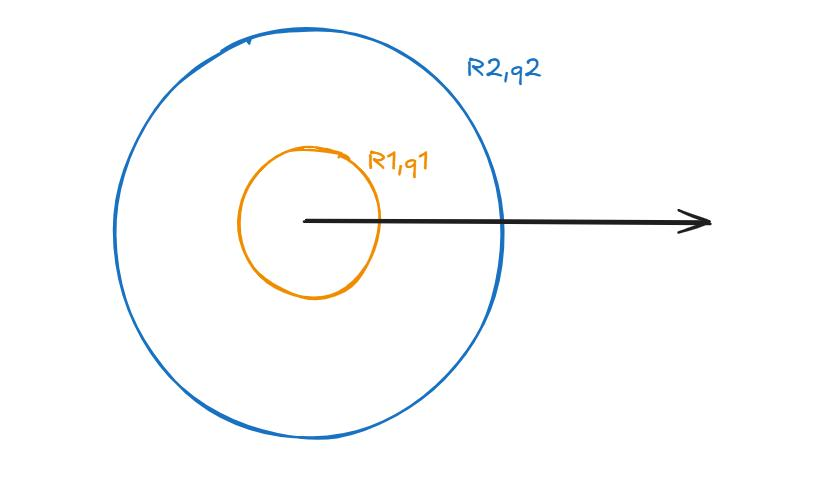

In [3]:
def t134():
    reset()
    r = Symbol('r', positive=True)
    radius = Symbol('R', positive=True)
    potential_of_surface = beautiful_formula('\\varphi_{sphere-of-surface}', beautiful_at(P, {
        (x ** 2 + y ** 2 + z ** 2): Piecewise((radius ** 2, r < radius), (r ** 2, r >= radius))}))
    R1, R2 = symbols('R1,R2')
    q1, q2 = symbols('q1,q2')
    p1 = beautiful_at(potential_of_surface, {radius: R1, charge: q1})
    p2 = beautiful_at(potential_of_surface, {radius: R2, charge: q2})

    pfull = beautiful_formula('\\varphi', (p1 + p2), "sum up:$")

    p1 = beautiful_at(pfull, {r: R1}, "potential on sphere 1:$").refine(Q.lt(R1, R2))
    beautiful_answer(p1, "that is:$")
    p2 = beautiful_at(pfull, {r: R2}, "potential on sphere 2:$").simplify(assumptions=Q.lt(R1, R2)).doit()
    p2 = p2.args[1][0]
    beautiful_answer(p2, "that is:$")
    p_ = (p1 - p2)
    p_ = p_.simplify()
    beautiful_answer(p_, "do sub of $P_{1} -P_{2}$:$")
    display(Markdown("always the sam sign with q1"))


t134()

$$\varphi\bigg|_{\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}=\begin{cases} R^{2} & \text{for}\: R > r \\r^{2} & \text{otherwise} \end{cases}}=\begin{cases} \frac{q}{4 \pi R \epsilon_{0}} & \text{for}\: R > r \\\frac{q}{4 \pi \epsilon_{0} r} & \text{otherwise} \end{cases}$$

$$\varphi_{sphere-of-surface}=\begin{cases} \frac{q}{4 \pi R \epsilon_{0}} & \text{for}\: R > r \\\frac{q}{4 \pi \epsilon_{0} r} & \text{otherwise} \end{cases}\tag{3}$$

$$\varphi_{sphere-of-surface}\bigg|_{R=R_{1}\,q=q_{1}}=\begin{cases} \frac{q_{1}}{4 \pi R_{1} \epsilon_{0}} & \text{for}\: R_{1} > r \\\frac{q_{1}}{4 \pi \epsilon_{0} r} & \text{otherwise} \end{cases}$$

$$\varphi_{sphere-of-surface}\bigg|_{R=R_{2}\,q=q_{2}}=\begin{cases} \frac{q_{2}}{4 \pi R_{2} \epsilon_{0}} & \text{for}\: R_{2} > r \\\frac{q_{2}}{4 \pi \epsilon_{0} r} & \text{otherwise} \end{cases}$$

sum up:$$\varphi=\begin{cases} \frac{q_{1}}{4 \pi R_{1} \epsilon_{0}} & \text{for}\: R_{1} > r \\\frac{q_{1}}{4 \pi \epsilon_{0} r} & \text{otherwise} \end{cases} + \begin{cases} \frac{q_{2}}{4 \pi R_{2} \epsilon_{0}} & \text{for}\: R_{2} > r \\\frac{q_{2}}{4 \pi \epsilon_{0} r} & \text{otherwise} \end{cases}\tag{4}$$

potential on sphere 1:$$\varphi\bigg|_{r=R_{1}}=\begin{cases} \frac{R_{1} q_{2} + R_{2} q_{1}}{4 \pi R_{1} R_{2} \epsilon_{0}} & \text{for}\: R_{1} < R_{2} \\\frac{q_{1} + q_{2}}{4 \pi R_{1} \epsilon_{0}} & \text{otherwise} \end{cases}$$

that is:$$\frac{R_{1} q_{2} + R_{2} q_{1}}{4 \pi R_{1} R_{2} \epsilon_{0}}\tag{answer}$$

potential on sphere 2:$$\varphi\bigg|_{r=R_{2}}=\begin{cases} \frac{R_{1} q_{2} + R_{2} q_{1}}{4 \pi R_{1} R_{2} \epsilon_{0}} & \text{for}\: R_{1} > R_{2} \\\frac{q_{1} + q_{2}}{4 \pi R_{2} \epsilon_{0}} & \text{otherwise} \end{cases}$$

that is:$$\frac{q_{1} + q_{2}}{4 \pi R_{2} \epsilon_{0}}\tag{answer}$$

do sub of $P_{1} -P_{2}$:$$\frac{q_{1} \left(- R_{1} + R_{2}\right)}{4 \pi R_{1} R_{2} \epsilon_{0}}\tag{answer}$$

always the sam sign with q1

# 13.9
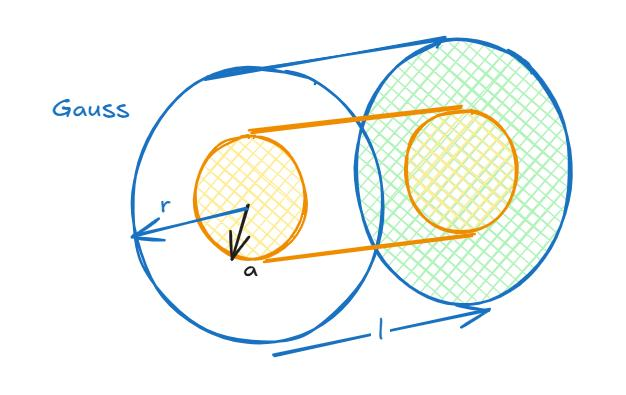

easily the charge within Gauss surface:$$q_{within}{\left(r \right)} = \begin{cases} \pi l r^{2} \rho & \text{for}\: a > r \\\pi a^{2} l \rho & \text{otherwise} \end{cases}$$

make the Gauss surface be a cylinder, and easily the flux of E is:$$\phi{\left(r \right)} = 2 \pi l r E_{r}{\left(r \right)}\tag{3}$$

$\left ( 1 \right ) ,\left ( 3 \right )  \Longrightarrow$

$$E_{r}{\left(r \right)} = \frac{q_{within}{\left(r \right)}}{2 \pi \epsilon_{0} l r}$$

$$\phi{\left(r \right)} = \frac{q_{within}{\left(r \right)}}{\epsilon_{0}}$$

$E$ inlined:$$\begin{cases} \frac{r \rho}{2 \epsilon_{0}} & \text{for}\: a > r \\\frac{a^{2} \rho}{2 \epsilon_{0} r} & \text{otherwise} \end{cases}\tag{answer}$$

since the cylinder is infinite, take the origin as the zero potential point:$$\varphi = - \int\limits_{0}^{r} E_{r}{\left(r \right)}\, dr$$

inlined:$$\begin{cases} - \frac{r^{2} \rho}{4 \epsilon_{0}} & \text{for}\: a \geq r \\- \frac{a^{2} \rho \left(\log{\left(\frac{r^{2}}{a^{2}} \right)} + 1\right)}{4 \epsilon_{0}} & \text{otherwise} \end{cases}\tag{answer}$$

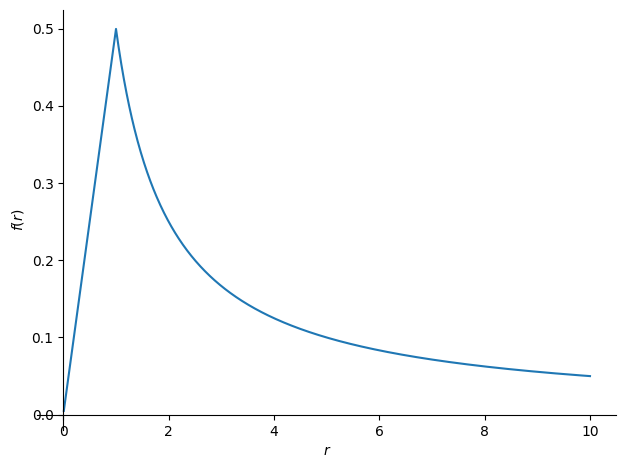

<lambdifygenerated-3>:2: RuntimeWarning: divide by zero encountered in log
  return select([less_equal(r, 1),True], [-1/4*r**2,-1/2*log(r) - 1/4], default=nan)
<lambdifygenerated-3>:2: RuntimeWarning: invalid value encountered in scalar multiply
  return select([less_equal(r, 1),True], [-1/4*r**2,-1/2*log(r) - 1/4], default=nan)


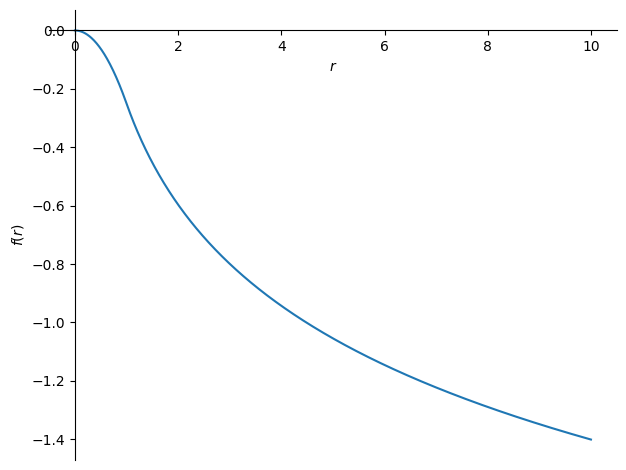

In [4]:
def t139():
    reset()

    dense = Symbol('rho', positive=True)
    length = Symbol('l', positive=True)
    a = Symbol('a', positive=True)
    r = Symbol('r', positive=True)
    q = beautiful_compute(Function('q_{within}')(r),
                          Piecewise((pi * r ** 2 * length * dense, r < a), (pi * a ** 2 * length * dense, r >= a)
                                    ), "easily the charge within Gauss surface:$")

    E_r = Function('E_r')(r)
    flux = Function('phi')(r)
    flu = beautiful_condition(Eq(flux, length * E_r * 2 * pi * r),
                              'make the Gauss surface be a cylinder, and easily the flux of E is:$')
    beautiful_solve([Gauss_law, flu], [flux, E_r], {electric_flux: flux, enclosed_charge_sum: q})
    beautiful_answer(E_r, "$E$ inlined:$")


    potential = beautiful_compute('varphi', integrate(-E_r, (r, 0, r)),
                                  "since the cylinder is infinite, take the origin as the zero potential point:$")
    potential =- Piecewise(
        (dense * r ** 2 / (4 * epsilon), r <= a),
        (dense * a ** 2 / (4 * epsilon) + dense * a ** 2 * log(r / a) / (2 * epsilon), True))
    beautiful_answer(potential, "inlined:$")
    save_as_variable(a, 1)
    save_as_variable(epsilon, 1)
    save_as_variable(dense, 1)

    plot(substitute_values(E_r), (r, 0, 10))
    plot(substitute_values(potential), (r, 0, 10))


t139()

# 1310
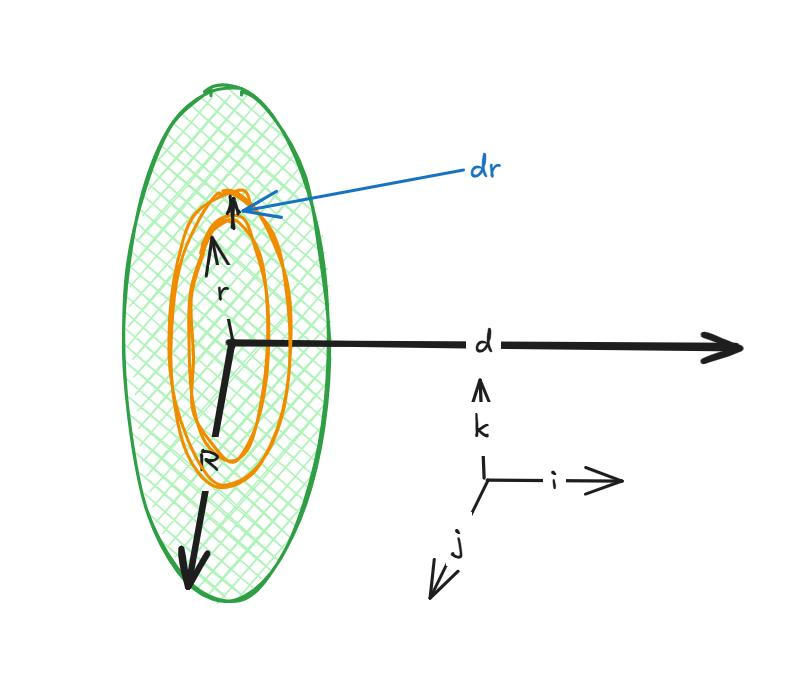

In [5]:
def t1310():
    reset()
    r= Symbol('r', positive=True)
    R = Symbol('R', positive=True)
    d =Symbol('d', positive=True)

    dense = Symbol('sigma', positive=True)


    dq = beautiful_compute(Function('dq')(r),2*pi*r*dense)

    dE = beautiful_at(E,{x:d,(y**2+z**2):r**2,charge:dq})

    EE = beautiful_compute('E_{byE}',coord.i*integrate(dot(dE,coord.i),(r,0,R)))
    beautiful_answer(EE,"inlined:$")
    Phi = beautiful_compute(Function('\\phi_{byE}')(d),lambda e: integrate(spf(EE),(d,d,oo)),"integrated to $\\phi_{byE}$:$")
    beautiful_answer(Phi,"inlined:$")

    dPhi = beautiful_at(P,{x:d,(y**2+z**2):r**2,charge:dq},"another way:$")
    Phi  = beautiful_compute(Function('phi')(d),integrate(dPhi,(r,0,R)))
    beautiful_peek(Phi,"inlined:$")


t1310()

$$\operatorname{dq}{\left(r \right)} = 2 \pi r \sigma$$

$$E\bigg|_{\mathbf{{x}_{}}=d\,\mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}=r^{2}\,q=\operatorname{dq}{\left(r \right)}}=\left(\frac{d \operatorname{dq}{\left(r \right)}}{4 \pi \epsilon_{0} \left(d^{2} + r^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} \operatorname{dq}{\left(r \right)}}{4 \pi \epsilon_{0} \left(d^{2} + r^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\mathbf{{z}_{}} \operatorname{dq}{\left(r \right)}}{4 \pi \epsilon_{0} \left(d^{2} + r^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{k}_{}}$$

$$E_{byE} = \left(\frac{d \int\limits_{0}^{R} \frac{\operatorname{dq}{\left(r \right)}}{d^{2} \sqrt{d^{2} + r^{2}} + r^{2} \sqrt{d^{2} + r^{2}}}\, dr}{4 \pi \epsilon_{0}}\right)\mathbf{\hat{i}_{}}$$

inlined:$$\left(- \frac{d \sigma}{2 \epsilon_{0} \sqrt{R^{2} + d^{2}}} + \frac{\sigma}{2 \epsilon_{0}}\right)\mathbf{\hat{i}_{}}\tag{answer}$$

integrated to $\phi_{byE}$:$$\phi_{byE}{\left(d \right)} = \left(- \frac{d \sigma}{2 \epsilon_{0}} + \frac{\sigma \sqrt{R^{2} + d^{2}}}{2 \epsilon_{0}}\right)\mathbf{\hat{i}_{}}$$

inlined:$$\left(\frac{\sigma \left(- d + \sqrt{R^{2} + d^{2}}\right)}{2 \epsilon_{0}}\right)\mathbf{\hat{i}_{}}\tag{answer}$$

another way:$$\varphi\bigg|_{\mathbf{{x}_{}}=d\,\mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}=r^{2}\,q=\operatorname{dq}{\left(r \right)}}=\frac{\operatorname{dq}{\left(r \right)}}{4 \pi \epsilon_{0} \sqrt{d^{2} + r^{2}}}$$

$$\phi{\left(d \right)} = \frac{\int\limits_{0}^{R} \frac{\operatorname{dq}{\left(r \right)}}{\sqrt{d^{2} + r^{2}}}\, dr}{4 \pi \epsilon_{0}}$$

inlined:$$\phi{\left(d \right)} = \frac{\sigma \left(- d + \sqrt{R^{2} + d^{2}}\right)}{2 \epsilon_{0}}$$

# 13.14
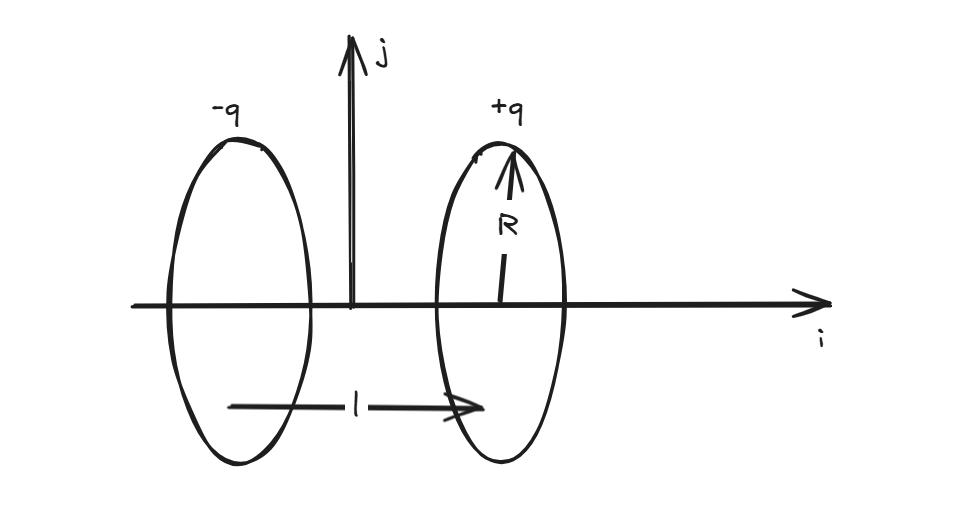


In [6]:
def t1314():
    reset()
    ch = Symbol('q', positive=True,)
    R = Symbol('R', positive=True)
    l = Symbol('l', positive=True)
    q1=beautiful_compute('q_1',-ch,"given:$")

    q2 = beautiful_compute('q_2',+ch,"given:$")

    pos = Symbol('x', positive=True)
    dx = Symbol('dx', positive=True)
    p1= beautiful_at(P,{charge:q1,x:pos+dx,(y**2+z**2):R**2})
    p2 = beautiful_at(P,{charge:q2,x:pos-dx,(y**2+z**2):R**2})

    PP = beautiful_compute(Function('P_{full}')(pos),p1+p2,"sum up:$")
    beautiful_answer(spf(PP).subs(dx,l/2),"inlined:$")

    P_appro = beautiful_compute('P_appro', series(spf(PP),dx,0,2),"series to 2nd:$")
    ssss = substitute_values(P_appro).subs(dx, l / 2).subs(O(l**2), 0)
    beautiful_print(ssss, "approximation:$")

    display(Markdown("as for $(2)$, this is very easy, just consider R to 0 , compare to x"))
    beautiful_answer(ssss.subs(R,0), "approximation:$")

t1314()

given:$$q_{1} = - q$$

given:$$q_{2} = q$$

$$\varphi\bigg|_{q=q_{1}\,\mathbf{{x}_{}}=dx + x\,\mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}=R^{2}}=\frac{q_{1}}{4 \pi \epsilon_{0} \sqrt{R^{2} + \left(dx + x\right)^{2}}}$$

$$\varphi\bigg|_{q=q_{2}\,\mathbf{{x}_{}}=- dx + x\,\mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}=R^{2}}=\frac{q_{2}}{4 \pi \epsilon_{0} \sqrt{R^{2} + \left(dx - x\right)^{2}}}$$

sum up:$$P_{full}{\left(x \right)} = \frac{q_{1}}{4 \pi \epsilon_{0} \sqrt{R^{2} + \left(dx + x\right)^{2}}} + \frac{q_{2}}{4 \pi \epsilon_{0} \sqrt{R^{2} + \left(dx - x\right)^{2}}}$$

inlined:$$- \frac{q}{2 \pi \epsilon_{0} \sqrt{4 R^{2} + \left(l + 2 x\right)^{2}}} + \frac{q}{2 \pi \epsilon_{0} \sqrt{4 R^{2} + \left(l - 2 x\right)^{2}}}\tag{answer}$$

series to 2nd:$$P_{appro} = \frac{dx q x}{2 \pi \epsilon_{0} \left(R^{2} + x^{2}\right)^{\frac{3}{2}}} + O\left(dx^{2}\right)$$

approximation:$$\frac{l q x}{4 \pi \epsilon_{0} \left(R^{2} + x^{2}\right)^{\frac{3}{2}}}$$

as for $(2)$, this is very easy, just consider R to 0 , compare to x

approximation:$$\frac{l q}{4 \pi \epsilon_{0} x^{2}}\tag{answer}$$